In [183]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.special import softmax
from numpy.random import multivariate_normal as mvn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Graphing Parameters
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

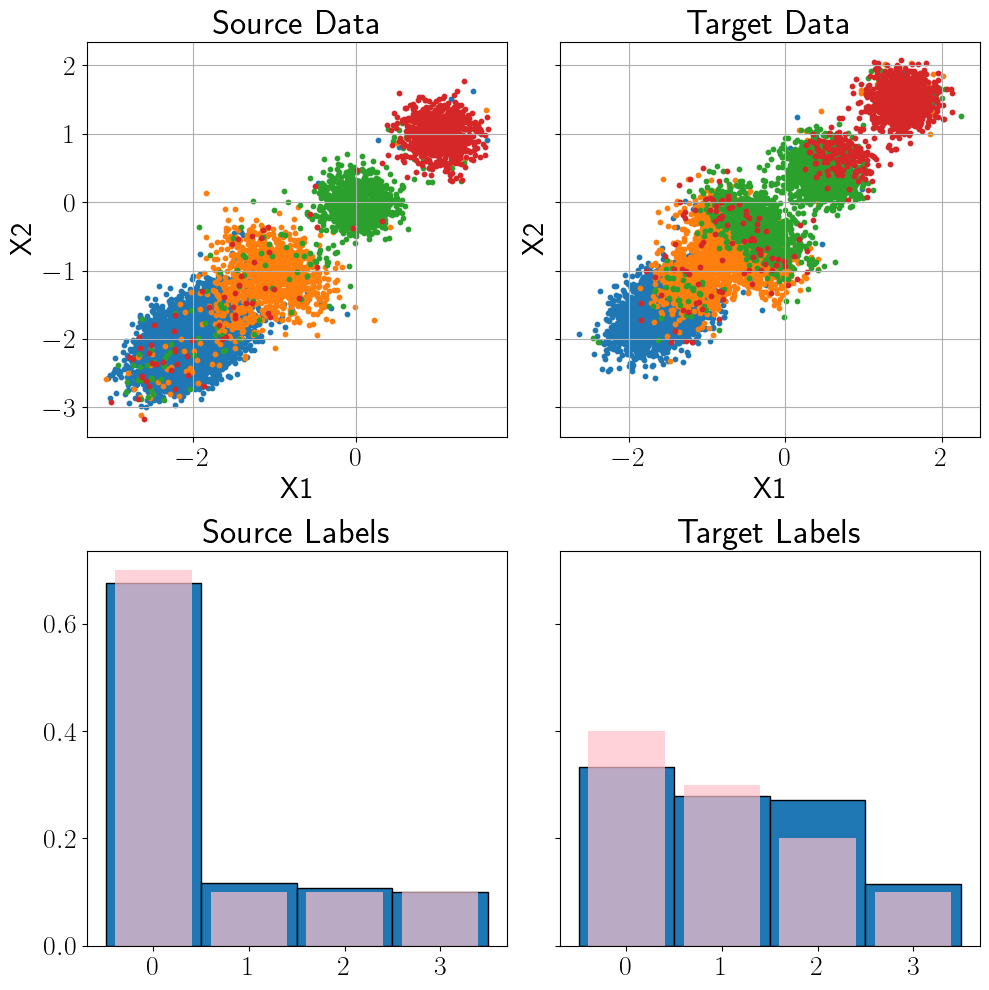

In [184]:

# 1. Define mixture components for bivariate Gaussians
mixture_weights_source = np.array([0.7, 0.1, 0.1, 0.1])  # mixture weights sum to 1
mixture_weights_target = np.array([0.4, 0.3, 0.2, 0.1])  # mixture weights sum to 1

diff = 0.5
means_source = [np.array([-2, -2]), np.array([-1, -1]), np.array([0, 0]), np.array([1, 1])]
means_target = [mean + diff for mean in means_source]

covs = [np.array([[.1, 0.05], [0.05, .1]]),
        np.array([[.1, -0.03], [-0.03, .1]]),
        np.array([[0.05, 0], [0, 0.05]]),
        np.array([[0.05, 0], [0, 0.05]])]

# 2. Define f_i(x) functions for class probabilities
def class_logits_source(x):
    """Returns raw scores (logits) for each of 4 classes given input x (2D)."""
    # Linear and nonlinear features
    x1, x2 = x[0], x[1]
    return np.array([
        np.exp(-(x1 + 2)**2 - (x2 + 2)**2)/0.15,
        np.exp(-(x1 + 1)**2 - (x2 + 1)**2)/0.2,
        np.exp(-(x1 - 0)**2 - (x2 - 0)**2)/0.15,
        np.exp(-(x1 - 1)**2 - (x2 - 1)**2)/0.2,
    ])

def class_logits_target(x, diff=0.1):
    """Returns raw scores (logits) for each of 4 classes given input x (2D)."""
    # Linear and nonlinear features
    x1, x2 = x[0], x[1]
    return np.array([
        np.exp(-(x1 + 2 - diff)**2 - (x2 + 2 - diff)**2)/0.15,
        np.exp(-(x1 + 1 - diff)**2 - (x2 + 1 - diff)**2)/0.2,
        np.exp(-(x1 - 0 - diff)**2 - (x2 - 0 - diff)**2)/0.15,
        np.exp(-(x1 - 1 - diff)**2 - (x2 - 1 - diff)**2)/0.2,
    ])

# 3. Sampling procedure
def sample_data(n_samples, mixture_weights, split='source'):
    X = []
    y = []
    for _ in range(n_samples):
        # Choose Gaussian component
        k = np.random.choice(len(mixture_weights), p=mixture_weights)
        if split == 'source':
            x = mvn(mean=means_source[k], cov=covs[k])
            class_logits = class_logits_source(x)
        else:
            x = mvn(mean=means_target[k], cov=covs[k])
            class_logits = class_logits_target(x, diff=0.2)
        probs = softmax(class_logits)  # Convert to probabilities
        label = np.random.choice(4, p=probs)
        X.append(x)
        y.append(label)
    return np.array(X), np.array(y)

# 4. Visualize sample
X_s, y_s = sample_data(10000, mixture_weights_source, split='source')
X_t, y_t = sample_data(10000, mixture_weights_target, split='target')

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row')
for i in range(4):
    axs[0,0].scatter(X_s[y_s == i, 0], X_s[y_s == i, 1], s=10, label=f'Class {i}')
axs[0,0].set_title("Source Data")
axs[0,0].set_xlabel("X1")
axs[0,0].set_ylabel("X2")
axs[0,0].grid(True)

for i in range(4):
    axs[0,1].scatter(X_t[y_t == i, 0], X_t[y_t == i, 1], s=10, label=f'Class {i}')
axs[0,1].set_title("Target Data")
axs[0,1].set_xlabel("X1")
axs[0,1].set_ylabel("X2")
axs[0,1].grid(True)

axs[1,0].hist(y_s, bins=np.arange(y_s.min(), y_s.max()+2)-0.5, edgecolor='black', density=True)
axs[1,0].bar(np.arange(y_s.min(), y_s.max()+1), mixture_weights_source, color='pink', alpha=0.7)
axs[1,0].set_xticks(np.arange(y_s.min(), y_s.max()+1))
axs[1,0].set_title("Source Labels")

axs[1,1].hist(y_t, bins=np.arange(y_t.min(), y_t.max()+2)-0.5, edgecolor='black', density=True)
axs[1,1].bar(np.arange(y_t.min(), y_t.max()+1), mixture_weights_target, color='pink', alpha=0.7)

axs[1,1].set_xticks(np.arange(y_t.min(), y_t.max()+1))
axs[1,1].set_title("Target Labels")
plt.tight_layout()
plt.show()


/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy: 0.947
Confusion matrix:
 [[1348   10    0    1]
 [  51  165    2    2]
 [   9   10  193    9]
 [   9    3    1  187]]


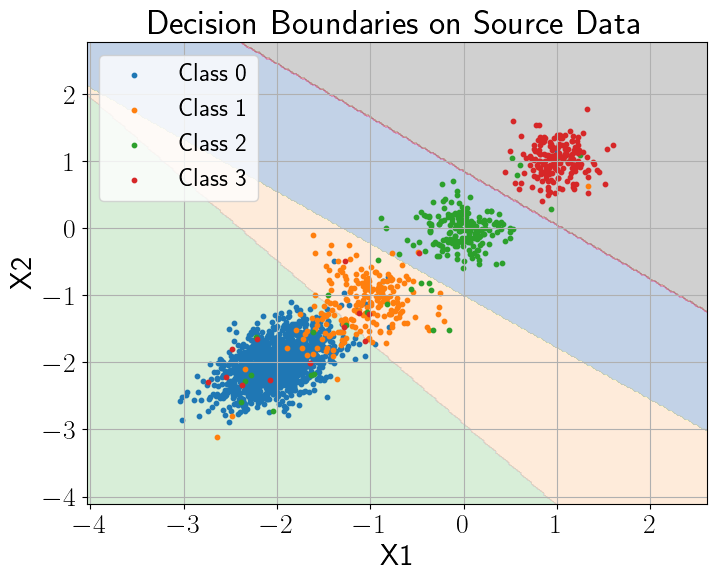

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# ---------- Step 3: Fit logistic regression ----------
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

# ---------- Step 4: Evaluate ----------
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test accuracy: {acc:.3f}")
print("Confusion matrix:\n", cm)

# ---------- Step 5: Visualize decision boundaries ----------
def plot_decision_boundary(clf, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, probs, alpha=0.3, cmap='Accent')
    for i in range(4):
        plt.scatter(X[y == i, 0], X[y == i, 1], s=10, label=f'Class {i}')
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_decision_boundary(clf, X_test, y_test, title="Decision Boundaries on Source Data")

Test accuracy: 0.724
Confusion matrix:
 [[2906  364   40   21]
 [ 121 1647  976   44]
 [  19   85 1637  982]
 [  11   38   55 1054]]


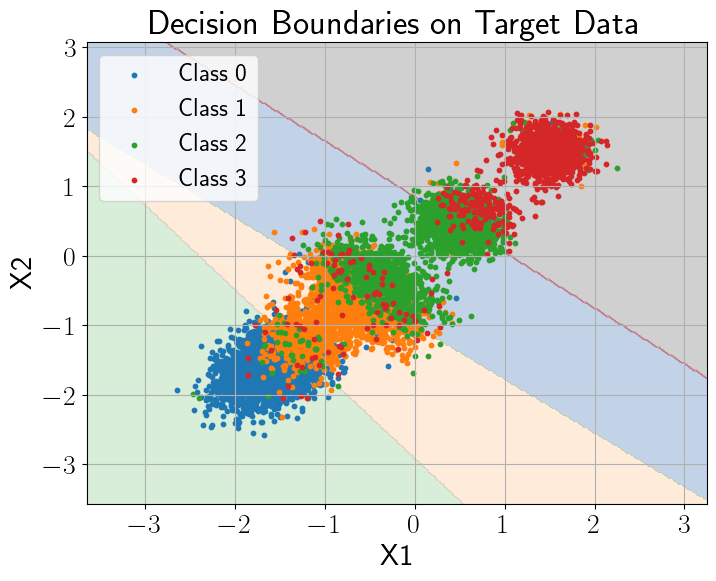

In [186]:
# ---------- Step 5: Evaluate on target data ----------
y_pred = clf.predict(X_t)
acc = accuracy_score(y_t, y_pred)
cm = confusion_matrix(y_t, y_pred)

print(f"Test accuracy: {acc:.3f}")
print("Confusion matrix:\n", cm)


# ---------- Step 6: Visualize decision boundaries ----------

plot_decision_boundary(clf, X_t, y_t, title="Decision Boundaries on Target Data")

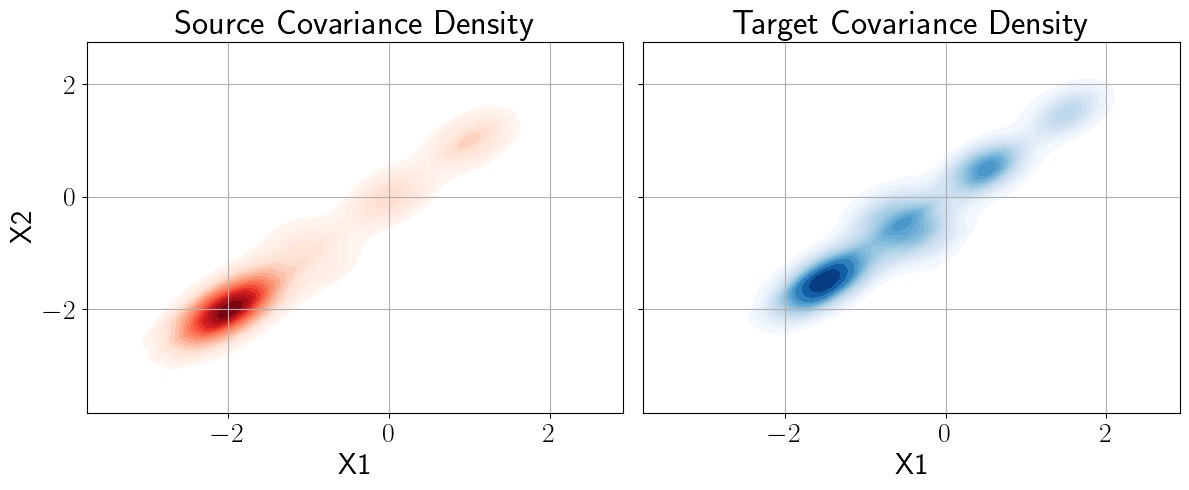

In [187]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Dataset 1
sns.kdeplot(x=X_s[:,0], y=X_s[:,1], cmap="Reds", fill=True, thresh=0.05, levels=20, ax=axs[0])
axs[0].set_title("Source Covariance Density")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].grid(True)

# Dataset 2
sns.kdeplot(x=X_t[:,0], y=X_t[:,1], cmap="Blues", fill=True, thresh=0.05, levels=20, ax=axs[1])
axs[1].set_title("Target Covariance Density")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X2")
axs[1].grid(True)

plt.tight_layout()
plt.show()

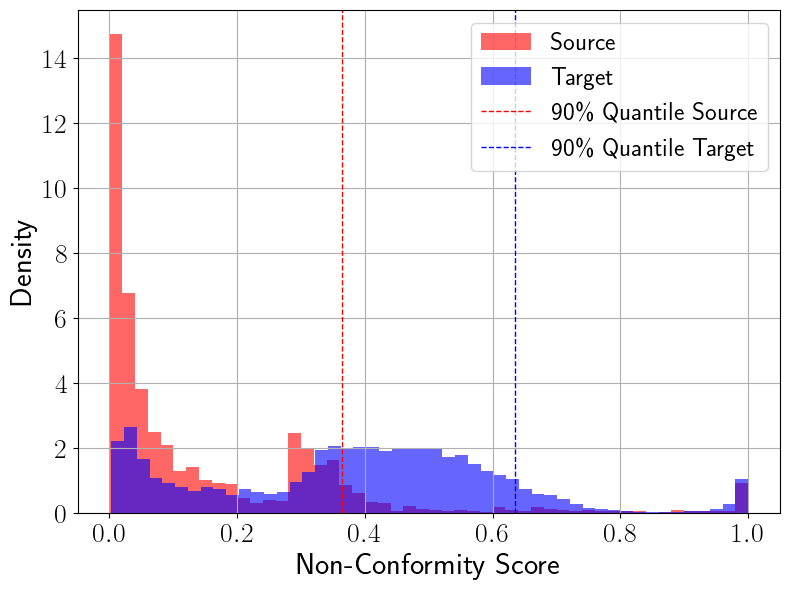

In [189]:
scores_cal_source = 1 - clf.predict_proba(X_cal)[np.arange(len(y_cal)), y_cal]
scores_target = 1 - clf.predict_proba(X_t)[np.arange(len(y_t)), y_t]

plt.figure(figsize=(8, 6))

plt.hist(scores_cal_source, bins=50, color='red', alpha=0.6, density=True, label='Source')
plt.hist(scores_target, bins=50, color='blue', alpha=0.6, density=True, label='Target')
plt.axvline(x=np.quantile(scores_cal_source, 0.90), color='red', linestyle='--', label='90\% Quantile Source')
plt.axvline(x=np.quantile(scores_target, 0.90), color='blue', linestyle='--', label='90\% Quantile Target')

plt.xlabel("Non-Conformity Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [191]:
from sklearn.cluster import MiniBatchKMeans
import ot

import numpy as np

def weighted_quantile(values, quantiles, sample_weight=None):
    """
    Compute weighted quantiles.
    
    Parameters
    ----------
    values : array-like, shape (N,)
        Data values
    quantiles : array-like
        List of quantiles in [0,1]
    sample_weight : array-like, shape (N,), optional
        Weights for each data point (default equal weights)
    
    Returns
    -------
    quantile_values : ndarray
        Weighted quantiles corresponding to `quantiles`
    """
    values = np.asarray(values)
    quantiles = np.asarray(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    else:
        sample_weight = np.asarray(sample_weight)

    # Sort data and associated weights
    sorter = np.argsort(values)
    values = values[sorter]
    sample_weight = sample_weight[sorter]

    # Compute the cumulative distribution
    weighted_cdf = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_cdf /= np.sum(sample_weight)

    return np.interp(quantiles, weighted_cdf, values)

def empirical_joint_prob(X, Y, n_x=100, n_y=4):
    """
    Compute empirical joint probability P_hat(x,y) from discrete data.
    
    Parameters
    ----------
    X : array-like, shape (N,)
        Discrete values for X (e.g., 0..n_x-1)
    Y : array-like, shape (N,)
        Discrete values for Y (e.g., 0..n_y-1)
    n_x : int
        Number of possible X classes
    n_y : int
        Number of possible Y classes
    
    Returns
    -------
    P_hat : ndarray, shape (n_x, n_y)
        Empirical joint distribution
    """
    X = np.asarray(X, dtype=int)
    Y = np.asarray(Y, dtype=int)
    N = len(X)

    counts = np.zeros((n_x, n_y), dtype=float)
    for xi, yi in zip(X, Y):
        counts[xi, yi] += 1

    P_hat = counts / N
    return P_hat

def compress_to_coreset(X_big, K=1000, batch_size=2048):
    km = MiniBatchKMeans(n_clusters=K, batch_size=batch_size, n_init='auto')
    km.fit(X_big)
    centers = km.cluster_centers_                     # (K, d)
    labels = km.predict(X_big)
    # weights proportional to cluster sizes:
    counts = np.bincount(labels, minlength=K).astype(float)
    a = counts / counts.sum()                         # (K,)
    return centers, a, labels, km

def ot_plan(cost, a=None, b=None):
    
    if a is None: a = np.full(cost.shape[0], 1.0/cost.shape[0])
    if b is None: b = np.full(cost.shape[1], 1.0/cost.shape[1])

    T = ot.emd(a, b, cost)
    return T, a, b

def sinkhorn(a, b, C, epsilon=1e-2, n_iter=1000, tol=1e-9):
    """
    Classic Sinkhorn algorithm (simple stable version).
    Inputs:
      a: (n,) source histogram (sums to 1)
      b: (m,) target histogram (sums to 1)
      C: (n,m) cost matrix
      epsilon: entropic regularization
    Returns:
      T: (n,m) transport plan with row-sum ~ a and col-sum ~ b
    """
    n = a.shape[0]; m = b.shape[0]
    K = np.exp(-C / epsilon)
    K[K < 1e-300] = 1e-300  # numerical floor
    u = np.ones(n)
    v = np.ones(m)
    for it in range(n_iter):
        u_prev = u.copy()
        u = a / (K @ v)
        v = b / (K.T @ u)
        if np.linalg.norm(u - u_prev, 1) < tol:
            break
    T = (u[:, None] * K) * v[None, :]
    return T

eps = 0.1
centers, a, labels, km = compress_to_coreset(X_t, K=100, batch_size=500)
C = - eps * np.log(clf.predict_proba(centers) + 1e-8)
# T = ot_plan(C, a, mixture_weights_target)[0]
T = sinkhorn(a, mixture_weights_target, C, epsilon=eps, n_iter=1000, tol=1e-9)


In [192]:
X_train_binned = km.predict(X_train)
X_cal_binned = km.predict(X_cal)

P_hat = empirical_joint_prob(X_cal_binned, y_cal, n_x=100, n_y=4)

importance_weights = T[X_cal_binned, y_cal]/P_hat[X_cal_binned, y_cal]
importance_weights = importance_weights/np.sum(importance_weights)

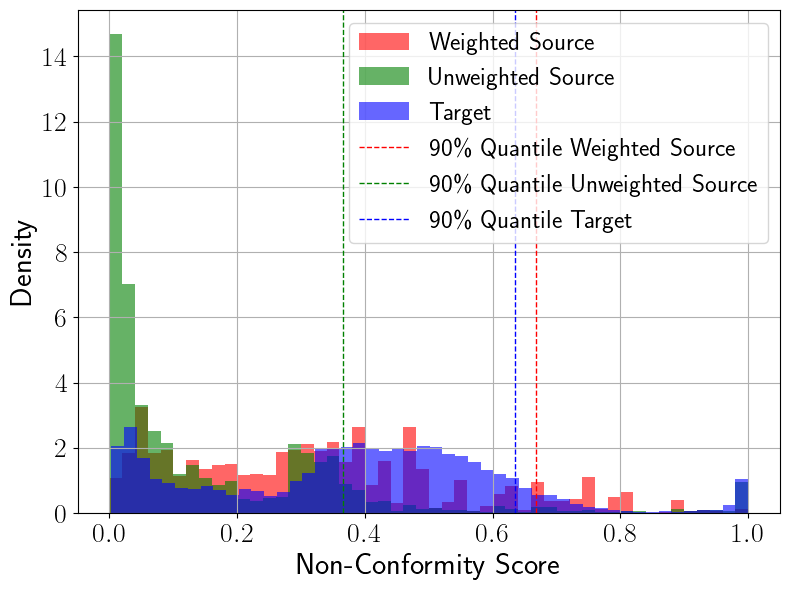

In [193]:
scores_cal_source =  ( 1 - clf.predict_proba(X_cal)[np.arange(len(y_cal)), y_cal])
scores_target = 1 - clf.predict_proba(X_t)[np.arange(len(y_t)), y_t]

plt.figure(figsize=(8, 6))

plt.hist(scores_cal_source, bins=50, color='red', alpha=0.6, density=True, label='Weighted Source', weights=importance_weights)
plt.hist(scores_cal_source, bins=50, color='green', alpha=0.6, density=True, label='Unweighted Source', weights=np.arange(len(y_cal))/len(y_cal))
plt.hist(scores_target, bins=50, color='blue', alpha=0.6, density=True, label='Target', weights=np.arange(len(y_t))/len(y_t))
plt.axvline(x=weighted_quantile(scores_cal_source, [0.9], sample_weight=importance_weights), color='red', linestyle='--', label='90\% Quantile Weighted Source')
plt.axvline(x=weighted_quantile(scores_cal_source, [0.9], sample_weight=None), color='green', linestyle='--', label='90\% Quantile Unweighted Source')
plt.axvline(x=weighted_quantile(scores_target, [0.9], sample_weight=None), color='blue', linestyle='--', label='90\% Quantile Target')

plt.xlabel("Non-Conformity Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy before OT fitting: 0.9375
Accuracy after OT fitting: 0.948


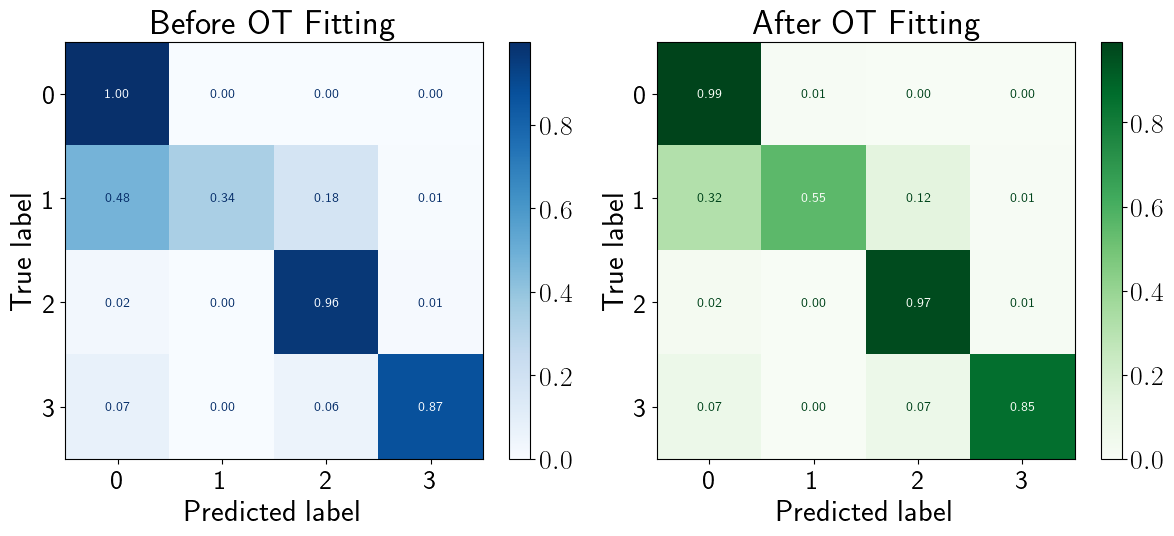

In [ ]:
import ot 
from sklearn.metrics import ConfusionMatrixDisplay

eps = 0.1
cost_source = - eps * np.exp(clf.predict_proba(X_cal)/eps)
a_source = np.ones(len(cost_source))/len(cost_source)
b_source = mixture_weights_source

gamma_source = ot.sinkhorn(a_source, b_source, cost_source, reg=0.1)
gamma_acc_source = np.mean(np.argmax(gamma_source, axis=1) == y_cal)

print(f"Accuracy before OT fitting: {np.mean(clf.predict(X_cal) == y_cal)}")
print(f"Accuracy after OT fitting: {np.mean(np.argmax(gamma_source, axis=1) == y_cal)}")

y_pred_before_ot = clf.predict(X_cal)
y_pred_after_ot = np.argmax(gamma_source, axis=1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Model 1
ConfusionMatrixDisplay.from_predictions(
    y_cal, y_pred_before_ot, ax=axes[0], cmap='Blues',
    normalize='true', values_format=".2f"
)

axes[0].set_title("Before OT Fitting")

# Model 2
ConfusionMatrixDisplay.from_predictions(
    y_cal, y_pred_after_ot, ax=axes[1], cmap='Greens',
    normalize='true', values_format=".2f"
)
axes[1].set_title("After OT Fitting")

plt.tight_layout()
plt.show()

Accuracy before OT fitting: 0.8335
Accuracy after OT fitting: 0.9415


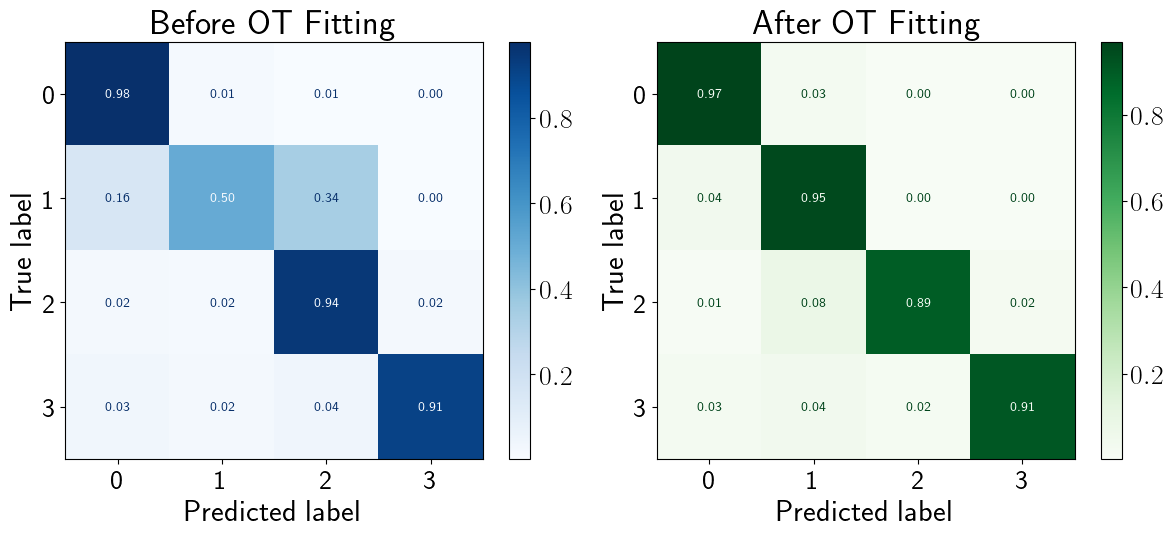

In [29]:
import ot 
from sklearn.metrics import ConfusionMatrixDisplay

cost_target = 1 - clf.predict_proba(X_t)
a_target = np.ones(len(cost_target))/len(cost_target)
b_target = mixture_weights_target

gamma_target = ot.sinkhorn(a_target, b_target, cost_target, reg=0.1)
gamma_acc_target = np.mean(np.argmax(gamma_target, axis=1) == y_t)

print(f"Accuracy before OT fitting: {np.mean(clf.predict(X_t) == y_t)}")
print(f"Accuracy after OT fitting: {np.mean(np.argmax(gamma_target, axis=1) == y_t)}")

y_pred_before_ot = clf.predict(X_t)
y_pred_after_ot = np.argmax(gamma_target, axis=1)
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Model 1
ConfusionMatrixDisplay.from_predictions(
    y_t, y_pred_before_ot, ax=axes[0], cmap='Blues',
    normalize='true', values_format=".2f"
)

axes[0].set_title("Before OT Fitting")

# Model 2
ConfusionMatrixDisplay.from_predictions(
    y_t, y_pred_after_ot, ax=axes[1], cmap='Greens',
    normalize='true', values_format=".2f"
)
axes[1].set_title("After OT Fitting")

plt.tight_layout()
plt.show()

In [ ]:
import ot 

cost_source = 1 - clf.predict_proba(X_cal)
cost_target = 1 - clf.predict_proba(X_t)

a_source = np.ones(len(cost_source))/len(cost_source)
b_source = mixture_weights_source

a_target = np.ones(len(cost_target))/len(cost_target)
b_target = mixture_weights_target

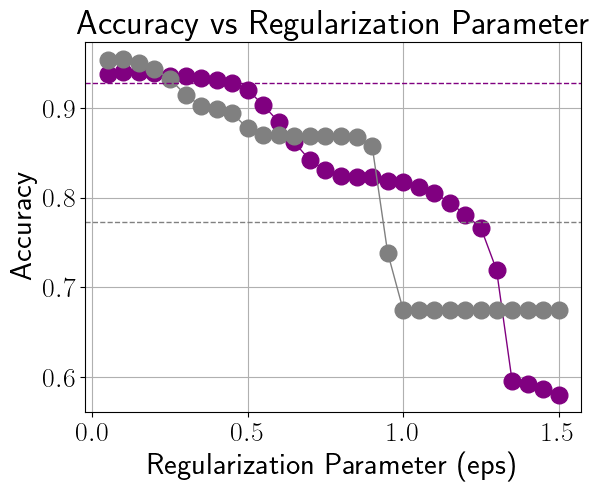

In [220]:
gamma_acc_eps_source = []
gamma_acc_eps_target = []

for eps in 0.05*np.arange(1,31):
    gamma_source = ot.sinkhorn(a_source, b_source, cost_source, reg=eps)
    gamma_target = ot.sinkhorn(a_target, b_target, cost_target, reg=eps)

    gamma_acc_source = np.sum(np.argmax(gamma_source, axis=1) == y_cal)/len(y_cal)
    gamma_acc_target = np.sum(np.argmax(gamma_target, axis=1) == y_t)/len(y_t)
    gamma_acc_eps_target.append(gamma_acc_source)
    gamma_acc_eps_source.append(gamma_acc_target)

plt.plot(0.05*np.arange(1,31), gamma_acc_eps_source, marker='o', label='Source Domain', color='purple')
plt.plot(0.05*np.arange(1,31), gamma_acc_eps_target, marker='o', label='Target Domain', color='grey')
plt.axhline(y = np.sum(np.argmax(clf.predict_proba(X_cal), axis=1) == y_cal)/len(y_cal), linestyle='--', color='purple')
plt.axhline(y = np.sum(np.argmax(clf.predict_proba(X_t), axis=1) == y_t)/len(y_t), linestyle='--', color='grey')

plt.xlabel("Regularization Parameter (eps)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Regularization Parameter")
plt.grid(True)
plt.show()